In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import pandas as pd

import re
import numpy as np
from PIL import Image

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = 'cpu'

In [20]:
transforms = transforms.Compose([transforms.ToTensor()])
def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    '''
    alist.sort(key=natural_keys) sorts in human order
    http://nedbatchelder.com/blog/200712/human_sorting.html
    (See Toothy's implementation in the comments)
    '''
    return [ atoi(c) for c in re.split(r'(\d+)', text) ]

class hdf5dataset(Dataset):
    '''
    Reads an HDF5 file with the following keys: train_data, train_labels, test_data, test_labels, test_ids. Train_data is a vector which is reshped to fit the shape variable. Works for both 2D and 3D input
    '''
    def __init__(self, h5_path, shape = (32,32), training = True, transforms=None, projection = False):
        st = pd.HDFStore(h5_path)
        self.store = st
        if training:
            self.data = st['train_data'].values
            self.label = st['train_labels'].values
        else:
            self.data = st['test_data'].values
            self.label = st['test_labels'].values
        self.transforms = transforms
        self.data_len = self.data.shape[0]
        self.shape = shape
        self.projection = projection
        
        # weight the classes by 1/#examples * maximum #examples, note that labels should start at 1
        # for example if the number of examples = [10, 50, 100] then self.weight = [10, 2, 1]
        count_labels = {}
        for item in self.label:
            if item: 
                key = "class_" + str(item)
                if not key in count_labels: count_labels[key] = 0
                count_labels[key] += 1 
        weights = []
        weights2 = []
        mysort = []
        for key in count_labels:
            mysort.append(key)
        mysort.sort(key = natural_keys)
        
        for key in mysort:
            weights.append(1. / count_labels[key])
            weights2.append(count_labels[key])
        
        weightsnp = np.asarray(weights)
        weights2np = np.asarray(weights2)
        maxnum = np.amax(weights2np)
        weightsnp = weightsnp*maxnum
        self.weight = torch.FloatTensor(weightsnp)
            
    def getIds(self):
        #get test serial ID for mapping back to the original image. 
        #NOTE: IDs should NOT be shuffled in order to keep ground truth label with the correct ID
        ids = self.store['test_ids'].values
        return ids
    
    def __getitem__(self, index):
        num_pixels = 1
        for dim in self.shape: num_pixels = num_pixels*dim
        img = self.data[index, 0:num_pixels]
        img = np.reshape(img, self.shape, order = 'C') #last index of shape changes fastest
        img = img.astype(float)
        img = np.float32(img) / 256
        #print(str(np.amin(img)))
        '''
        if self.projection:
            img = np.amax(img, axis = 0)
        '''
        label = self.label[index] - 1 #labeling starts at 0 for CNN
        
        # Perform augmentation. The data loader differentiates between training and test transformations, this simply sends the batch to receive the transformations
        if self.transforms is not None:
            if len(self.shape) > 2 and not self.projection: #3D input
                for transform in self.transforms:
                    img = transform(img)
                img_as_tensor = img
                #img_as_tensor = img_as_tensor.type(torch.FloatTensor)
            elif self.projection:
                img_as_img = Image.fromarray(img) #convert to PIL
                img_as_img = img_as_img.resize((60,60), resample=Image.NEAREST)
                img_as_img = img_as_img.resize((100,100), resample=Image.NEAREST)
                img_as_img = img_as_img.resize((256,256), resample=Image.NEAREST)
                rgbimg = Image.new("RGB", img_as_img.size, color=(0,0,0))
                rgbimg.paste(img_as_img)
                values =  list(rgbimg.getdata())
                new_image= rgbimg.point(lambda argument: argument*1)
                img_as_tensor = self.transforms(new_image)
            else: #2D input
                image = img.astype(float)
                img_as_img = Image.fromarray(image)
                img_as_tensor = self.transforms(img_as_img)
        return img_as_tensor, label

    def __len__(self):
        return self.data_len
    
train_dataset = hdf5dataset('C:/Users/awoloshu/Desktop/datasets/tubules_only/2d_max/2d_max_tubules.h5', transforms = transforms)
test_dataset = hdf5dataset('C:/Users/awoloshu/Desktop/datasets/tubules_only/2d_max/2d_max_tubules.h5', transforms = transforms,training = False)

In [21]:
BATCH_SIZE = 64         # number of data points in each batch
N_EPOCHS = 100           # times to run the model on complete data
INPUT_DIM = 32*32     # size of each input
HIDDEN_DIM = 256        # hidden dimension
LATENT_DIM = 10         # latent vector dimension
N_CLASSES = 7          # number of classes in the data
lr = 1e-3               # learning rate

In [22]:
train_iterator = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_iterator = DataLoader(test_dataset, batch_size=BATCH_SIZE)

def idx2onehot(idx, n=N_CLASSES):

    assert idx.shape[1] == 1
    assert torch.max(idx).item() < n

    onehot = torch.zeros(idx.size(0), n)
    onehot.scatter_(1, idx.data, 1)

    return onehot

class Encoder(nn.Module):
    ''' This the encoder part of VAE

    '''
    def __init__(self, input_dim, hidden_dim, latent_dim, n_classes):
        '''
        Args:
            input_dim: A integer indicating the size of input (in case of MNIST 28 * 28).
            hidden_dim: A integer indicating the size of hidden dimension.
            latent_dim: A integer indicating the latent size.
            n_classes: A integer indicating the number of classes. (dimension of one-hot representation of labels)
        '''
        super().__init__()

        self.linear = nn.Linear(input_dim + n_classes, hidden_dim)
        self.mu = nn.Linear(hidden_dim, latent_dim)
        self.var = nn.Linear(hidden_dim, latent_dim)

    def forward(self, x):
        # x is of shape [batch_size, input_dim + n_classes]

        hidden = F.relu(self.linear(x))
        # hidden is of shape [batch_size, hidden_dim]

        # latent parameters
        mean = self.mu(hidden)
        # mean is of shape [batch_size, latent_dim]
        log_var = self.var(hidden)
        # log_var is of shape [batch_size, latent_dim]

        return mean, log_var
    
class Decoder(nn.Module):
    ''' This the decoder part of VAE

    '''
    def __init__(self, latent_dim, hidden_dim, output_dim, n_classes):
        '''
        Args:
            latent_dim: A integer indicating the latent size.
            hidden_dim: A integer indicating the size of hidden dimension.
            output_dim: A integer indicating the size of output (in case of MNIST 28 * 28).
            n_classes: A integer indicating the number of classes. (dimension of one-hot representation of labels)
        '''
        super().__init__()

        self.latent_to_hidden = nn.Linear(latent_dim + n_classes, hidden_dim)
        self.hidden_to_out = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # x is of shape [batch_size, latent_dim + num_classes]
        x = F.relu(self.latent_to_hidden(x))
        # x is of shape [batch_size, hidden_dim]
        generated_x = F.sigmoid(self.hidden_to_out(x))
        # x is of shape [batch_size, output_dim]

        return generated_x
    
class CVAE(nn.Module):
    ''' This the VAE, which takes a encoder and decoder.

    '''
    def __init__(self, input_dim, hidden_dim, latent_dim, n_classes):
        '''
        Args:
            input_dim: A integer indicating the size of input (in case of MNIST 28 * 28).
            hidden_dim: A integer indicating the size of hidden dimension.
            latent_dim: A integer indicating the latent size.
            n_classes: A integer indicating the number of classes. (dimension of one-hot representation of labels)
        '''
        super().__init__()

        self.encoder = Encoder(input_dim, hidden_dim, latent_dim, n_classes)
        self.decoder = Decoder(latent_dim, hidden_dim, input_dim, n_classes)

    def forward(self, x, y):

        x = torch.cat((x, y), dim=1)

        # encode
        z_mu, z_var = self.encoder(x)

        # sample from the distribution having latent parameters z_mu, z_var
        # reparameterize
        std = torch.exp(z_var / 2)
        eps = torch.randn_like(std)
        x_sample = eps.mul(std).add_(z_mu)

        z = torch.cat((x_sample, y), dim=1)

        # decode
        generated_x = self.decoder(z)

        return generated_x, z_mu, z_var

In [23]:
def calculate_loss(x, reconstructed_x, mean, log_var):
    # reconstruction loss
    assert (x.data.cpu().numpy().all() >= 0. and x.data.cpu().numpy().all() <= 1.)
    assert (reconstructed_x.data.cpu().numpy().all() >= 0. and reconstructed_x.data.cpu().numpy().all() <= 1.)
    RCL = F.binary_cross_entropy(reconstructed_x, x, size_average=False)
    # kl divergence loss
    KLD = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())

    return RCL + KLD

def train():
    # set the train mode
    model.train()

    # loss of the epoch
    train_loss = 0

    for i, (x, y) in enumerate(train_iterator):
        # reshape the data into [batch_size, 784]
        x = x.view(-1, INPUT_DIM)
        x = x.to(device)

        # convert y into one-hot encoding
        y = idx2onehot(y.view(-1, 1))
        y = y.to(device)

        # update the gradients to zero
        optimizer.zero_grad()

        # forward pass
        reconstructed_x, z_mu, z_var = model(x, y)

        # loss
        loss = calculate_loss(x, reconstructed_x, z_mu, z_var)

        # backward pass
        loss.backward()
        train_loss += loss.item()

        # update the weights
        optimizer.step()

    return train_loss

def test():
    # set the evaluation mode
    model.eval()

    # test loss for the data
    test_loss = 0

    # we don't need to track the gradients, since we are not updating the parameters during evaluation / testing
    with torch.no_grad():
        for i, (x, y) in enumerate(test_iterator):
            # reshape the data
            x = x.view(-1,INPUT_DIM)
            x = x.to(device)

            # convert y into one-hot encoding
            y = idx2onehot(y.view(-1, 1))
            y = y.to(device)

            # forward pass
            reconstructed_x, z_mu, z_var = model(x, y)

            # loss
            loss = calculate_loss(x, reconstructed_x, z_mu, z_var)
            test_loss += loss.item()

    return test_loss


In [24]:
# model
model = CVAE(INPUT_DIM, HIDDEN_DIM, LATENT_DIM, N_CLASSES)
model.to(device)
#optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)
best_test_loss = 9999999999
for e in range(N_EPOCHS):

    train_loss = train()
    test_loss = test()

    train_loss /= len(train_dataset)
    test_loss /= len(test_dataset)

    print(f'Epoch {e}, Train Loss: {train_loss:.2f}, Test Loss: {test_loss:.2f}')

    if best_test_loss > test_loss:
        best_test_loss = test_loss
        patience_counter = 1
    else:
        patience_counter += 1

    if patience_counter > 3:
        break

Epoch 0, Train Loss: 105.95, Test Loss: 94.39
Epoch 1, Train Loss: 94.05, Test Loss: 93.04
Epoch 2, Train Loss: 93.29, Test Loss: 92.71
Epoch 3, Train Loss: 93.06, Test Loss: 92.59
Epoch 4, Train Loss: 92.94, Test Loss: 92.49


KeyboardInterrupt: 

Generating a pct1


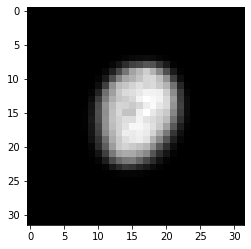

Generating a pct2


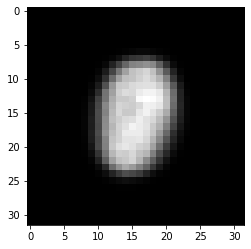

Generating a tal


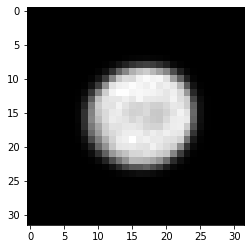

Generating a dct


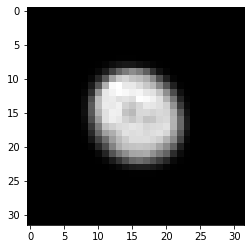

Generating a cd


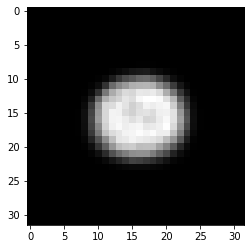

Generating a cd45


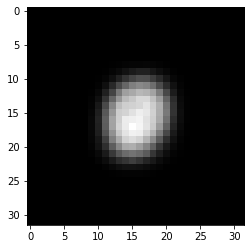

Generating a nestin


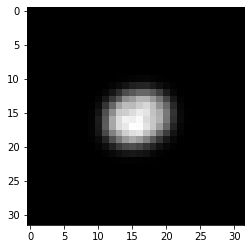

In [26]:
# create a random latent vector

def generateImage(model, label):
    z = torch.randn(1, LATENT_DIM).to(device)
    classes = ['pct1', 'pct2', 'tal', 'dct', 'cd', 'cd45', 'nestin']
    # pick randomly 1 class, for which we want to generate the data
    y = torch.randint(label, label+1, (1, 1)).to(dtype=torch.long)
    print(f'Generating a {classes[y.item()]}')

    y = idx2onehot(y).to(device, dtype=z.dtype)
    z = torch.cat((z, y), dim=1)

    reconstructed_img = model.decoder(z)
    img = reconstructed_img.view(32, 32).data

    plt.figure()
    plt.imshow(img.cpu(), cmap='gray')
    plt.show()
    
for i in range(N_CLASSES):
    generateImage(model, i)